In [1]:
# Google Colab library
try:
    from google.colab import drive
    import torch_xla.core.xla_model as xm
    
    print("In Google Colab")
except:
    print("Not in Google Colab")
    pass

Not in Google Colab


In [2]:
# Python library
import os
import zipfile
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import pickle as pkl
import yaml
import albumentations as A

from glob import glob
from tqdm import tqdm
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed

# Sklearn library
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Pytorch library
import torch
from torch import optim, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# CV2 library
import cv2

c:\Users\fxlqt\.conda\envs\Py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
print("Cuda version: ", torch.version.cuda)

Device:  cuda
Cuda version:  12.4


In [4]:
# Load configuration
with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Project information
print('Project name: ', config['project']['name'])
print('Project version: ', config['project']['description'])
print('Project author: ', config['project']['author'])
print('Project version: ', config['project']['version'])

# Data location
print('Data path: ', config['data'])
data_path = config['data']['raw_path']
csv_path = config['data']['raw_csv_path']
images_path = config['data']['raw_images_path']

# Training configuration
n_workers = config['hyperparameters']['n_workers']
batch_size = config['hyperparameters']['batch_size']
print('N workers: ', n_workers)
print('Batch size: ', batch_size)

# Preprocessing configuration
print('Preprocessing configuration')
augmentation_ratio = config['preprocessing']['augmentation']['ratio']
resize_shape = tuple(config['preprocessing']['resize'])
print('Augmentation ratios: ', augmentation_ratio)
print('Resize shape: ', resize_shape)

# Create a dictionary for images location
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Project name:  Cancer Detection
Project version:  DPL302m Project - Fall 2024 of Group 1
Project author:  Group 1
Project version:  1.0.0
Data path:  {'data_path': 'data/', 'raw_path': 'data/raw/', 'raw_csv_path': 'data/raw/HAM10000_metadata.csv', 'raw_images_path': 'data/raw/images/', 'processed_path': 'data/processed/', 'processed_images_path': 'data/processed/images/'}
N workers:  8
Batch size:  32
Preprocessing configuration
Augmentation ratios:  1
Resize shape:  (64, 64)


In [5]:
from scripts.preprocessing import *

preprocessor = DataProcessor(config_path='config.yaml')
preprocessor.run(aug=True, rate = 1)

Raw data shape: (10015, 7)
Data shape: (10015, 7)

Data types:
lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

Unique values for each column:
dx: ['mel' 'nv' 'bkl' 'bcc' 'akiec']...
dx_type: ['histo' 'consensus' 'follow_up' 'confocal']...
age: [65. 40. 35. 45. 55.]...
sex: ['male' 'female' 'unknown']...
localization: ['face' 'lower extremity' 'back' 'trunk' 'abdomen']...

NaN values in each column:
age    57
dtype: int64

Unknown values in each column:
sex: 57
localization: 234

Summary of potential data issues:
- Columns with NaN values: ['age']
- Columns with 'unknown' values: ['sex', 'localization']
Data after cleaning:
        lesion_id                          image_id   dx    dx_type  age  \
1617  HAM_0007180  data/raw/images/ISIC_0033272.jpg  mel      histo   65   
8128  HAM_0007195  data/raw/images/ISIC_0031923.jpg   nv      histo   40   
2168  

100%|██████████| 62/62 [00:01<00:00, 52.41it/s]


   dx_code  count
5        5   5239
4        4    858
2        2    845
1        1    410
0        0    256
6        6    112
3        3     88
Number of images: 7808, Number of rows in data: 7808


Augmenting Images: 100%|██████████| 7808/7808 [00:02<00:00, 3333.64it/s] 


Augmented train data shape: (35841, 6)
Augmented train images shape: (64, 64, 3)
Train data labels shape: (35841,)
Raw test data shape: (1953, 6)
Saving data...
Saving train data...


Processing Batches: 100%|██████████| 1121/1121 [00:01<00:00, 711.82it/s]


Means: [0.57870805 0.55357807 0.75827369]
Stdevs: [0.18213722 0.16921878 0.15605204]
Saving test data...


Processing Batches: 100%|██████████| 62/62 [00:00<00:00, 742.15it/s]


Means: [0.56834591 0.54455169 0.76232629]
Stdevs: [0.16985847 0.15205254 0.14029671]
Data preprocessing completed in 18.48 seconds.


In [6]:
# Step 2: Model building
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = config

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    # Variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "Densenet121":
        weights = 'DEFAULT' if use_pretrained else None
        model_ft = models.densenet121(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = config['preprocessing']['resize'][0]
    
    elif model_name == "Resnet18":
        # Add initialization for Resnet18 if needed
        pass

    else:
        print("Invalid model name, exiting...")
        exit()
    

    return model_ft, input_size

# Step 3: Model training
model_name = "Densenet121"
num_classes = config['hyperparameters']['num_classes']
feature_extract = config['hyperparameters']['feature_extract']
use_pretrained = config['hyperparameters']['use_pretrained']


# Initialize the model for this run and move it to the device
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained)
model = model_ft.to(device)

# Print the model we just instantiated
print(model_ft)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
class HAM10000(Dataset):
    def __init__(self, data_file):
        # Load the merged data
        data = torch.load(data_file)
        self.images = data['images']
        self.labels = data['data']
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        X = self.images[index]
        y = torch.tensor(self.labels[index])
        return X, y

# Define location of prepared data
size = config['preprocessing']['resize'][0]

encoder_file = f'encoder/{size}x{size}.pt'
train_data_file = f'data/processed/HAM10000_{size}x{size}_train.pt'
test_data_file = f'data/processed/HAM10000_{size}x{size}_test.pt'

# Load the encoder
encoder = torch.load(encoder_file)

# Load the training data
train_data = HAM10000(train_data_file)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)

# Load the test data
test_data = HAM10000(test_data_file)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

C:\Users\fxlqt\AppData\Local\Temp\ipykernel_23180\798468676.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load(encoder_file)
C:\Users\fxlqt\AppData\Lo

In [8]:
# We use Adam optimizer, use cross entropy loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [9]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def train(train_loader, model, criterion, optimizer, epoch, report_freq=100):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % report_freq == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [11]:
def validate(test_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [12]:
total_loss_train, total_acc_train = [],[]
epoch_num = 10
# epoch_num = config['hyperparameters']['epochs']
print('Start training...  on image size: ', config['preprocessing']['resize'], ' with epoch: ', epoch_num)
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    print('Training on epoch {}'.format(epoch))
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch, report_freq=100)
    loss_val, acc_val = validate(test_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('Best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

Start training...  on image size:  [64, 64]  with epoch:  10
Training on epoch 1
[epoch 1], [iter 100 / 1121], [train loss 1.97154], [train acc 0.23031]
[epoch 1], [iter 200 / 1121], [train loss 1.90433], [train acc 0.26047]
[epoch 1], [iter 300 / 1121], [train loss 1.89046], [train acc 0.27135]
[epoch 1], [iter 400 / 1121], [train loss 1.89539], [train acc 0.26922]
[epoch 1], [iter 500 / 1121], [train loss 1.89517], [train acc 0.27231]
[epoch 1], [iter 600 / 1121], [train loss 1.89732], [train acc 0.26807]
[epoch 1], [iter 700 / 1121], [train loss 1.89614], [train acc 0.26826]
[epoch 1], [iter 800 / 1121], [train loss 1.89434], [train acc 0.26906]
[epoch 1], [iter 900 / 1121], [train loss 1.88773], [train acc 0.27132]
[epoch 1], [iter 1000 / 1121], [train loss 1.88119], [train acc 0.27437]
[epoch 1], [iter 1100 / 1121], [train loss 1.87325], [train acc 0.27747]
------------------------------------------------------------
[epoch 1], [val loss 1.61011], [val acc 0.51109]
---------------

In [26]:
# Save the model
# Check the name of last model in the folder
model_path = 'saved_models/'
# Model name style is time, date, resize, epoch, acc
model_name = f'{time.strftime("%H-%M-%S_%d-%m-%Y")}_size{size}_epoch{epoch_num}_acc{best_val_acc:.2f}.pth'
model_name = os.path.join(model_path, model_name)
torch.save(model.state_dict(), model_name)
print('Model saved: ', model_name)

Model saved:  saved_models/13-47-32_21-10-2024_size64_epoch10_acc0.51.pth


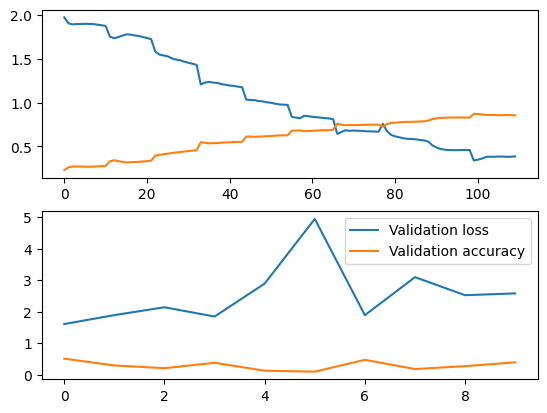

In [13]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'Training loss')
fig1.plot(total_acc_train, label = 'Training accuracy')
fig2.plot(total_loss_val, label = 'Validation loss')
fig2.plot(total_acc_val, label = 'Validation accuracy')
plt.legend()
plt.show()

In [16]:
# Classification report

AttributeError: 'dict' object has no attribute 'classes_'